### 데이터 확인
* rating: 제품에 대한 평점
* date: 리뷰 작성 날짜
* variation: 제품의 색상 및 기타 변형 정보
* verified_reviews: 실제 리뷰 텍스트
* feedback: 긍정적인 피드백 여부 (1: 긍정적, 0: 부정적)

# 데이터 로드 및 확인

In [1]:
import pandas as pd

# 데이터 파일 경로
file_path = 'data/amazon_alexa.tsv'
# 데이터 로드
alexa_data = pd.read_csv(file_path, sep='\t')
# 데이터 상위 5개 행 확인
alexa_data.head()


,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1
2,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1
3,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1
4,5,31-Jul-18,Charcoal Fabric,Music,1


# 텍스트 전처리

### null, 공백 리뷰 제거, 불용어 제거, 소문자 변환

In [3]:
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# NLTK 불용어 리스트 다운로드
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

# 불용어 리스트 가져오기
stop_words = set(stopwords.words('english'))

# null 및 공백 리뷰 제거
empty_review = alexa_data['verified_reviews'].replace(' ', '') == ''
null_review = alexa_data['verified_reviews'].isnull()

# null 및 공백 제거된 데이터프레임 생성
cleaned_df = alexa_data.drop(alexa_data[empty_review | null_review].index)

# 텍스트 전처리 함수
def preprocess_text(text):
    # 소문자 변환
    text = text.lower()
    # 특수 문자 및 숫자 제거
    text = re.sub(r'[^a-z\s]', '', text)
    # 토큰화
    words = word_tokenize(text)
    # 불용어 제거
    words = [word for word in words if word not in stop_words]
    return ' '.join(words)

# 전처리 적용
cleaned_df['cleaned_reviews'] = cleaned_df['verified_reviews'].apply(preprocess_text)

# 전처리 후 데이터 확인
cleaned_df[['verified_reviews', 'cleaned_reviews']].head()


[nltk_data] Downloading package punkt to /Users/jhjoo/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /Users/jhjoo/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /Users/jhjoo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,verified_reviews,cleaned_reviews
0,Love my Echo!,love echo
1,Loved it!,loved
2,"Sometimes while playing a game, you can answer...",sometimes playing game answer question correct...
3,I have had a lot of fun with this thing. My 4 ...,lot fun thing yr old learns dinosaurs control ...
4,Music,music


# 감성 레이블 설정(긍정/부정 분류)

In [5]:
# 감성 레이블 설정 (평점이 4 이상이면 긍정적, 그 이하는 부정적)
cleaned_df['sentiment'] = alexa_data['rating'].apply(lambda x: 1 if x >= 4 else 0)

# 간단한 리뷰 텍스트와 감성 레이블 확인
cleaned_df[['cleaned_reviews', 'sentiment']].head()


,cleaned_reviews,sentiment
0,love echo,1
1,loved,1
2,sometimes playing game answer question correct...,1
3,lot fun thing yr old learns dinosaurs control ...,1
4,music,1


# 텍스트 백터화 및 모델 학습 준비

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# 텍스트 벡터화 (TF-IDF)
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(cleaned_df['cleaned_reviews'])

# 감성 레이블
y = cleaned_df['sentiment']

# 학습/테스트 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 로지스틱 회귀 모델 학습
model = LogisticRegression()
model.fit(X_train, y_train)

# 예측 및 정확도 평가
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"모델 정확도: {accuracy:.4f}")


모델 정확도: 0.8990


# 토픽 모델링(LDA 사용)
> 토픽 모델링은 리뷰 데이터에서 주요 주제를 도출하는 데 유용합니다. 이를 위해 *Latent Dirichlet Allocation (LDA)* 를 사용합니다. 이 방법은 각 리뷰에 여러 주제가 혼합되어 있을 수 있음을 가정하고, 각 리뷰가 어떤 주제에 얼마나 관련 있는지를 계산합니다.

In [7]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

# CountVectorizer를 사용해 텍스트를 토큰화 및 벡터화 (단어 빈도 기반)
vectorizer = CountVectorizer(max_features=5000, stop_words='english')
X = vectorizer.fit_transform(cleaned_df['cleaned_reviews'])

# LDA 모델 설정
lda = LatentDirichletAllocation(n_components=5, random_state=42)  # 5개의 토픽을 추출
lda.fit(X)

# 각 토픽에 대해 주요 단어들을 출력하는 함수
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic #{topic_idx}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))
        print()

# 주요 단어 출력
n_top_words = 10
feature_names = vectorizer.get_feature_names_out()
print_top_words(lda, feature_names, n_top_words)


Topic #0:
like echo great music alexa far works product learning time

Topic #1:
echo music dot love sound like im alexa better play

Topic #2:
love echo alexa bought plus alarm hub amazon like spot

Topic #3:
great works easy love sound use good alexa set speaker

Topic #4:
love use tv new like stick easy amazon alexa fun



# 긍정/부정 예측 모델
> 이제 머신러닝 모델을 적용해 리뷰 텍스트 기반으로 제품 만족도를 예측하는 모델을 구축할 수 있습니다. 앞서 사용한 로지스틱 회귀 모델 외에도 여러 모델을 적용할 수 있습니다. 예를 들어, 랜덤 포레스트(Random Forest)나 서포트 벡터 머신(SVM)을 사용할 수 있습니다. 여기서는 간단히 랜덤 포레스트를 예시로 설명드리겠습니다.

In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# 텍스트 데이터를 벡터화 (TF-IDF 사용)
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(cleaned_df['cleaned_reviews'])

# 감성 레이블
y = cleaned_df['sentiment']

# 학습/테스트 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 랜덤 포레스트 모델 학습
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# 예측 및 정확도 평가
y_pred = rf_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"랜덤 포레스트 모델 정확도: {accuracy:.4f}")


랜덤 포레스트 모델 정확도: 0.9316


# 평점 예측 모델링

In [9]:
## 데이터 준비 및 벡터화

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# 텍스트 벡터화 (TF-IDF)
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(cleaned_df['cleaned_reviews'])

# 평점(rating) 데이터 준비
y = cleaned_df['rating']  # 1~5 사이의 평점

# 학습/테스트 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


## 모델 학습(RF)

In [11]:
# 랜덤 포레스트 모델 학습 (다중 클래스 분류)
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# 예측
y_pred = rf_model.predict(X_test)

# 정확도 평가
accuracy = accuracy_score(y_test, y_pred)
print(f"평점 예측 모델 정확도: {accuracy:.4f}")


평점 예측 모델 정확도: 0.8355


## 모델 성능 평가 (혼동 행렬 및 분류 보고서)

In [12]:
# 혼동 행렬 및 분류 보고서 출력
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print("혼동 행렬:")
print(conf_matrix)
print("\n분류 보고서:")
print(class_report)


혼동 행렬:
[[  5   0   1   2  17]
 [  0   4   0   0   9]
 [  0   0  14   1  13]
 [  0   0   0  32  56]
 [  0   0   0   2 458]]

분류 보고서:
              precision    recall  f1-score   support

           1       1.00      0.20      0.33        25
           2       1.00      0.31      0.47        13
           3       0.93      0.50      0.65        28
           4       0.86      0.36      0.51        88
           5       0.83      1.00      0.90       460

    accuracy                           0.84       614
   macro avg       0.93      0.47      0.57       614
weighted avg       0.85      0.84      0.80       614



# 시각화

## 감성 분석 시각화

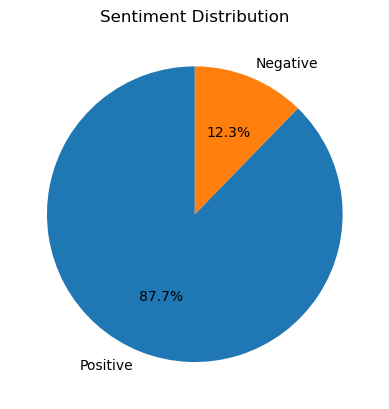

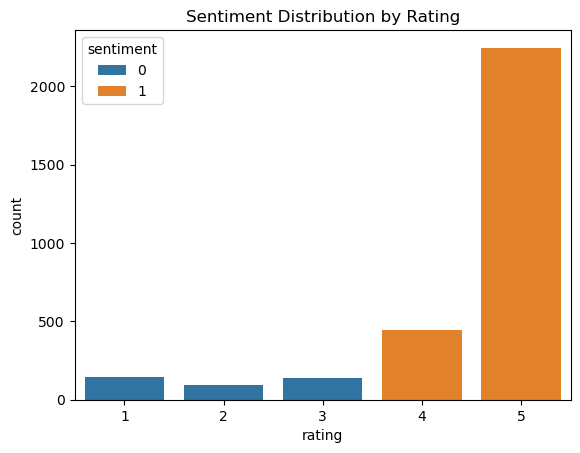

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# 감성 비율 시각화 (파이 차트)
sentiment_counts = cleaned_df['sentiment'].value_counts()
plt.pie(sentiment_counts, labels=['Positive', 'Negative'], autopct='%1.1f%%', startangle=90)
plt.title('Sentiment Distribution')
plt.show()

# 평점에 따른 감성 분포 (막대 그래프)
sns.countplot(x='rating', hue='sentiment', data=cleaned_df)
plt.title('Sentiment Distribution by Rating')
plt.show()


## 토픽 모델링 결과 시각화 (워드 클라우드)

In [16]:
!pip install wordcloud

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.4/169.4 kB 5.5 MB/s eta 0:00:00


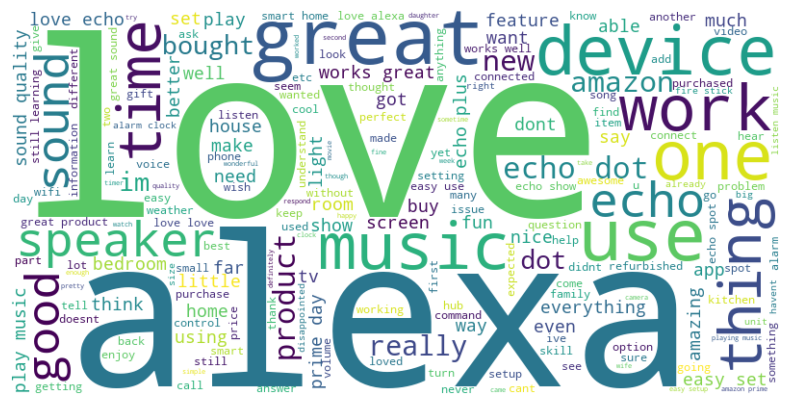

In [17]:
from wordcloud import WordCloud

# 특정 토픽의 주요 단어를 워드 클라우드로 시각화
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(cleaned_df['cleaned_reviews']))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


## 분류 모델 시각화

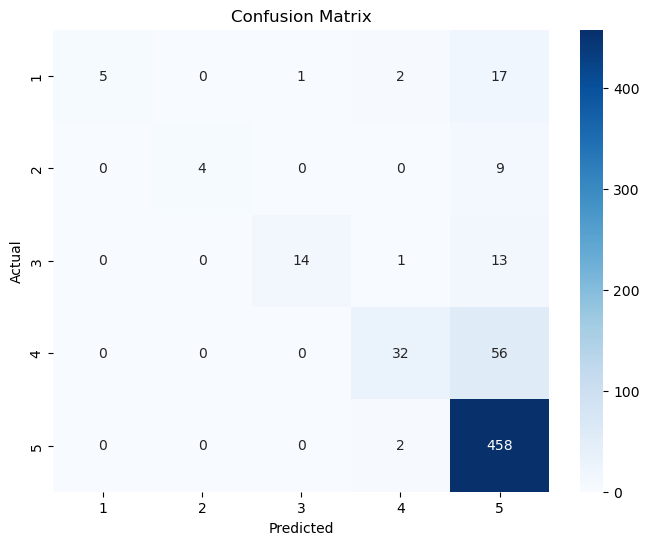

In [19]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 혼동 행렬 생성
conf_matrix = confusion_matrix(y_test, y_pred)

# 혼동 행렬 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[1, 2, 3, 4, 5], yticklabels=[1, 2, 3, 4, 5])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


### 오분류 된 리뷰 확인

In [21]:
# 예측 결과 저장 (y_pred는 이미 예측된 결과)
cleaned_df['predicted_rating'] = rf_model.predict(X)
# 실제 값과 예측 값 비교
mismatched_reviews = cleaned_df[cleaned_df['rating'] != cleaned_df['predicted_rating']]
# 잘못 예측된 리뷰들 확인
mismatched_reviews[['verified_reviews', 'rating', 'predicted_rating']]


,verified_reviews,rating,predicted_rating
31,I like it,4,5
42,So far so good,4,5
57,Great sound and easy to set up.,4,5
98,Love it!,4,5
145,it's annoying that everything they show Alexa ...,3,5
...,...,...,...
2837,I liked linking two more rooms in the home,4,5
2844,I've only got to use it for a couple of weeks ...,4,5
2992,love it,4,5
3074,I like almost everything,4,5
